# Time Series 


### Basic

시간에 따른 일련의 데이터를 Time series data라고 합니다. <br>
단 한개의 변수로 이루어진 time series를 **univariate** 이라고 하며, 2개 이상의 변수로 이루어진 time series를 **multivariate**이라고 합니다.


### Trend, Cyclical, Seasonal, Irregular 

Time series는 일반적으로 4개의 요소 (Trend, Cyclical, Seasonal 그리고 Irregular)에 의해 영향을 받습니다.

| Name | Description |
|:-----|:------------|
| **Trend(추세)** |  장기적인 관점에서 봤을때 그래프가 증가하는지, 감소하는지, 또는 정체되어 있는지등의 추세를 Trend라고 합니다.<br>Trend는 따라서 time series안에서 long term movement를 보는 것이 중요합니다. |
| **Seasonality(계절성)** | 특정 구간동안의 (1년, 한달, 일주일..) 변동성(fluctuations)를 나타냅니다. <br>예를 들어서 아이스크림 판매량은 여름에 늘어나고, 외투는 겨운에 판매량이 늘어날 것입니다. 또는 피트니스센터의 고객은 매년 결심을 하는 1월 초에 가장많은 사람들이 나올것입니다. 하지만 매월초가 될수도 있고, 매주초가 될 수도 있습니다. 따라서 피트니스센터는 년, 월, 주단위 seasonality를 갖고 있다고 할수 있습니다. |
| **Cycle(주기)** | Seasonality는 특정 기간에 정확하게 나타나는 변동성을 갖고 있는 반면, Cycle의 경우 특정 시간에 구애 받지 않습니다. 하지만 동일하게 특정 패턴을 갖고 있습니다. 보통 2~3년처럼 장기간에 걸친 패턴을 갖고 있을수 있습니다. 예를 들어서 business cycle의 경우에는 호황 -> 불황 -> 침체 -> 회복 의 cycle을 갖고 있습니다. | 
| **Irregularity(불규칙성)** | 또는 random variations이라고 불리며 예상치 못한 영향에 의해서 나타납니다. 예를 들어서 전쟁, 지진, 홍수, 혁명등등이 될 수 있습니다. |



# Import

In [273]:
%pylab inline
import pandas as pd
from pandas.plotting import lag_plot, autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.ar_model import AR
from sklearn.metrics import mean_squared_error
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

Populating the interactive namespace from numpy and matplotlib


# Data

아래의 링크에서 데이터를 다운받을 수 있습니다.<br>
[Daily minimum temperatures in Melbourne, Australia, 1981-1990](https://datamarket.com/data/set/2324/daily-minimum-temperatures-in-melbourne-australia-1981-1990#!ds=2324&display=line)

[Header]
Date
1981-01-01    20.7
1981-01-02    17.9
1981-01-03    18.8
1981-01-04    14.6
1981-01-05    15.8
Name: Daily minimum temperatures in Melbourne, Australia, 1981-1990, dtype: float64

Train Size: (3350, 1)
Test Size : (300, 1)


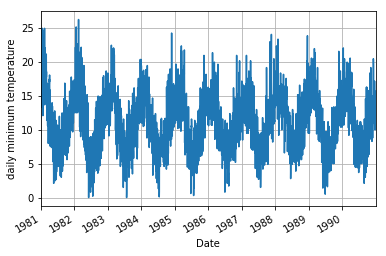

In [368]:
TEST_SIZE = 300

_filename= '/dataset/daily-minimum-temperature-in-melbourne/daily-minimum-temperatures-in-me.csv'
data = pd.Series.from_csv(_filename, header=0)
data.index = data.index.to_datetime()
data = data.astype('float64')
print('[Header]')
print(data.head())
data.plot(grid=True)
ylabel('daily minimum temperature')

# Normalization 
scaler = MinMaxScaler()
data = scaler.fit_transform(data.values.reshape((-1, 1)))

# Split Training and Test Data
train, test = data[:-TEST_SIZE], data[-TEST_SIZE:]
# train, test = train_test_split(data, test_size=0.1)
# train_data, test_data = data[0:len(data)-7], data[len(data)-7:]
print()
print('Train Size:', train.shape)
print('Test Size :', test.shape)

# Autocorrelation Checking

Autoregression은 이전의 time-steps의 observations을 통해 다음 step의 값을 예측하는데 사용될 수 있다는 가정을 갖고 있습니다.<br>
variables관의 관계를 correlation이라고 하며, 두 variables이 동시에 증가하거나 감소하면 **positive correlation**이라고 하며, 서로 반대방향으로 움직인다면 (하나는 증가하고, 하나는 감소하는 상황.) **negative correlation**이라고 합니다.

output variable (예측값) 그리고 이전 time-steps의 값(lagged variables)들의 correlation을 구함으로서 통계적 측정을 할 수 있습니다.<br>
correlation을 통해서 얼마만큼의 lag variables을 사용해야될지 알 수 있으며, 그래프가 predictable한지 안 한지도 알 수 있습니다.

> Autocorrelation에서 auto가 붙는 이유는 위에서 설명했듯이, 자기자신(auto or self)의 데이터를 사용하여 자기 자신의 데이터를 예측하기 때문에 이렇게 이름이 지어졌습니다.



### Lag Plot 

빠르게 correlation이 존재하는지 확인하는 방법은 step t 와 t-1 을 scatter plot으로 그래서 확인하는 방법입니다.<br>
집접 데이터를 가공해서 만들수도 있지만, Pandas에서는 lag_plot이라는 함수를 통해서 쉽게 lag plot을 그려볼 수 있습니다.


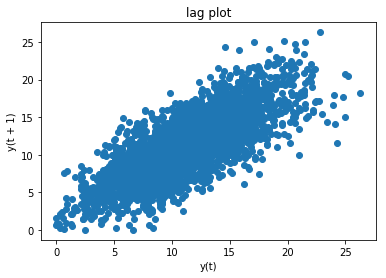

In [76]:
lag_plot(data, lag=1)
title('lag plot')

step t 와 step t-1 의 관계가 전혀 없는 random한 상황속에서는 다음과 같이 그래프가 그려집니다.

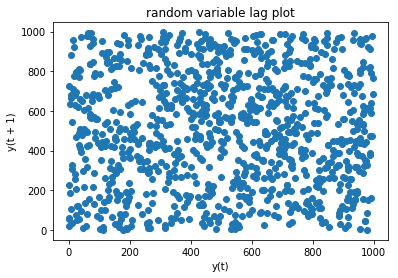

In [69]:
series = pd.Series([np.random.randint(0, 1000) for _ in range(1000)])
lag_plot(series)
title('random variable lag plot')

### Pearson Correlation Coefficient

t-1 과 t의 상관관계를 pearson correlation으로 구할수 있습니다. <br>

* negative correlated: -1 
* positive correlated: 1
* correlation: 0.5보다 크거나, -0.5보다 작을시 높은 correlation

아래의 예제에서는 0.77487의 correlation값을 보이는데 positive correlated이며 correlation이 높다고 할 수 있습니다.

In [77]:
data2 = pd.concat([data.shift(2), data.shift(1), data], axis=1)
data2.columns = ['t-2', 't-1', 't']
data2.corr()

,t-2,t-1,t
t-2,1.000000,0.774886,0.631119
t-1,0.774886,1.000000,0.774870
t,0.631119,0.774870,1.000000


### Autocorrelation Plot

각각의 lag variable에 대한 correlation을 plotting할 수 도 있지만, Pandas에서 이미 지원해주고 있습니다.

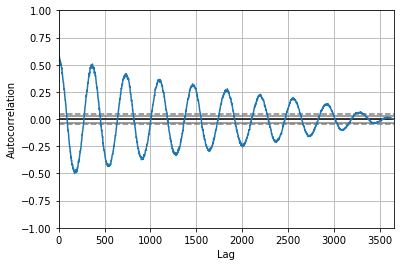

In [46]:
autocorrelation_plot(data.values)

statsmodel 라이브러리에서 제공하는 plot_acf를 사용할수도 있습니다.

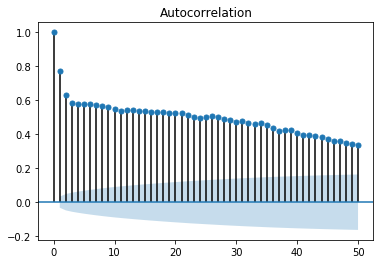

In [59]:
plot_acf(data, lags=50)
print(end='')

Random variable의 경우에는 다음과 같이 전혀 맞지 않게 나옵니다.

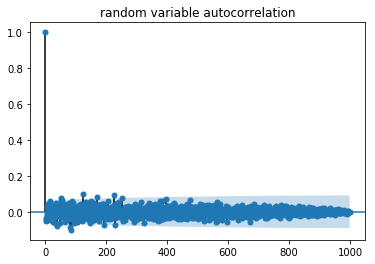

In [65]:
series = pd.Series([np.random.randint(0, 1000) for _ in range(1000)])
plot_acf(series, title='random variable autocorrelation')
print()

# AR (Autoregressive) Model

AR(p) (AutoRegressive of order p)는 간단하게 과거의 패턴이 지속된다면 <br>
시계열 데이터 관측치 $ y_t $ 는 과거 관측치 $ y_{t-1} $, $ y_{t-2} $, $ y_{t-3} $, ... 에 의해 예측될 수 있다고 봅니다. <br>
오직 과거의 데이터(lagged variables)만 사용해서 예측 모형을 만들게 되며, 이름도 autoregressive 입니다. (그리스어로 auto 라는 뜻은 "self"를 가르킵니다.)<br>



$$ \begin{align}
X_t &= \alpha_1 X_{t-1} + ... + \alpha_p X_{t-p} + \epsilon_t + c  \\
&= c + \sum^p_{i=1} \alpha_i X_{t-i} + \epsilon_t
\end{align}$$ 

* **order:** $ p $
* **parameters (coefficients):** $ \alpha_1 $, $ \alpha_2 $, ..., $ \alpha_p $
* **error term (white noise):** $ \epsilon_t $

### Example - 2 lagged variables

예를 들어서 $ X_t $값을 이전 2 steps ($ t-1 $ 그리고 $ t-2 $)의 관측치로 예측을 할 수 있습니다.

$$ X_t = \alpha_1 X_{t-1} + \alpha_2 X_{t-2} + \epsilon_t $$

In [370]:
train = train.reshape(-1)
model = AR(train)
model = model.fit(disp=True, callback=haha)

Lag: 29
Params: [ 0.02017463  0.58569696 -0.08432199  0.05070746  0.03697434  0.03765027
  0.02875159  0.04407822  0.01484929  0.03053277  0.00206854  0.00618082
  0.01797958  0.02210545  0.00232378  0.02217458  0.01216958  0.01093396
  0.04067089 -0.00402158  0.02313439  0.00738344  0.01176277 -0.02144451
  0.00664144  0.01407199  0.02349111  0.00664219  0.01110352 -0.00784639]
MSE: 0.0382885283023
0.643758358256
[ 0.31738356]


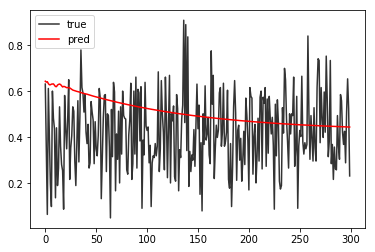

In [372]:
PRED_N = 300
model = AR(train)
model = model.fit(disp=True)

pred = model.predict(start=len(train), 
                     end=len(train) + PRED_N-1, 
                     dynamic=False)

print('Lag:', model_fit.k_ar)
print('Params:', model.params)
print('MSE:', mean_squared_error(pred, test_data[:PRED_N]))
plot(test_data[:PRED_N], label='true', color="#333333")
plot(pred, label='pred', color='red')
legend()

print(pred[0])
window = model.k_ar
lags = train_data[len(train_data)-window:]
p = model.params[0]
for i in range(window):
    
    p += model.params[i] * lags[i]
    
print(p)

In [231]:
pred = model.predict(start=29, end=len(train_data)-1, dynamic=False)

print(mean_squared_error(pred, train_data[29:]))

1.62038123252


# Auto-Regressive Integrated Moving Average (ARIMA)

ARIMA를 적용하기 위해서는 time series는 linear 하며 통계적 분포(normal distribution같은 statistical distribution)을 따른다고 가정합니다. <br>
다음의 모델들의 특징을 모두 갖고 있습니다.

* Autoregressive (AR)
* Moving Average (MA)

# References 

* http://users.dma.unipi.it/~flandoli/AUTCap4.pdf
* https://gejza.nipax.cz/_media/stochasticke_procesy:1302.6613.pdf
* https://onlinecourses.science.psu.edu/stat510/
* http://homepage.stat.uiowa.edu/~rdecook/stat2020/notes/ch5_pt1.pdf